In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
HLA_associations_path = os.path.abspath("../")
sys.path.append(HLA_associations_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import constants, index_tools, data_tools, medical_code_tools
from utilities import *

In [2]:
sns.set_palette("tab10")

# Load BioBank Components

In [34]:
DEV_MODE = False
biobank_data, biobank_index, med_code_mapping = data_tools.load_all_biobank_components(DEV_MODE, signifier="cancer")

Importing BioBank Index and Data:
Missing 0 biobank index names
UK BioBank Data Loaded.
Size: 41700 rows x 2781 columns
Elapsed time: 13.4974 seconds


Mapping ICD10 Codes: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2327/2327 [01:39<00:00, 23.46 feature/s]


# Constants

In [37]:
female_specific_cancers = ["breast cancer", "female genital tract cancer", "cervical cancer",
                           "cin/pre-cancer cells cervix", "fallopian tube cancer", "ovarian cancer",
                           "uterine/endometrial cancer", "vaginal cancer", "vulval cancer" ]

male_specific_cancers = ["male genital tract cancer", "penis cancer", "prostate cancer", "testicular cancer"]
sex_specific_cancers = female_specific_cancers + male_specific_cancers

 # Basic Summary stats

In [38]:
cancer_data = biobank_data.loc[~biobank_data["cancer_code"].isna()]

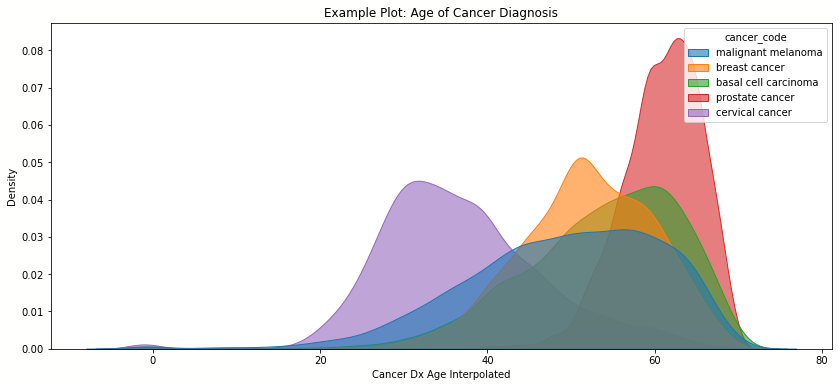

In [79]:
cancer_codes, counts = np.unique(cancer_data["cancer_code"], return_counts=True)

common_cancer_codes = cancer_codes[np.argsort(counts,)[-5:]]
common_cancer_data = cancer_data.loc[cancer_data["cancer_code"].isin(common_cancer_codes)]

fig, ax = plt.subplots(figsize=(14, 6), facecolor="#fffffe")
sns.kdeplot(data=common_cancer_data, x="cancer_dx_age_interpolated", hue="cancer_code", ax=ax,
            cumulative=False, shade=True, common_norm=False, bw_method=.2, alpha=.6)
ax.set_title("Example Plot: Age of Cancer Diagnosis")
add_plt_labels(ax, "cancer_dx_age_interpolated", "Density")
fig.savefig(constants.COVER_PLOTS_GENERIC_FILE_PATH.format("cancer_dx_age.png"), facecolor="#fffffe")

In [74]:
variables_of_interest = ["sex", "cancer_code"]

grouping_df = cancer_data[variables_of_interest].copy(deep=True)
grouping_df["total"] = grouping_df["sex"] != "nothing"
grouping_df["female"] = grouping_df["sex"] == "Female"
grouping_df["male"] = grouping_df["sex"] == "Male"
grouping_df = grouping_df.groupby("cancer_code").sum().reset_index()

grouping_df = grouping_df.loc[ ~grouping_df["cancer_code"].isin(sex_specific_cancers)]
grouping_df = grouping_df.query("total > 5").sort_values("total", ascending=False)
most_common_cancers = grouping_df["cancer_code"]

grouping_df["male_fraction"] = grouping_df["male"] / grouping_df["total"]
grouping_df["female_fraction"] = grouping_df["female"] / grouping_df["total"]
grouping_df

,cancer_code,total,female,male,male_fraction,female_fraction
4,basal cell carcinoma,4064,2402,1662,0.408957,0.591043
34,malignant melanoma,3477,2072,1405,0.404084,0.595916
14,colon cancer/sigmoid cancer,1472,624,848,0.576087,0.423913
64,skin cancer,1354,680,674,0.497784,0.502216
5,bladder cancer,1049,278,771,0.734986,0.265014
...,...,...,...,...,...,...
3,appendix cancer,13,8,5,0.384615,0.615385
71,thymus cancer / malignant thymoma,10,5,5,0.500000,0.500000
55,peripheral nerve/autonomic nerve cancer,10,4,6,0.600000,0.400000
37,metastatic cancer (unknown primary),9,6,3,0.333333,0.666667


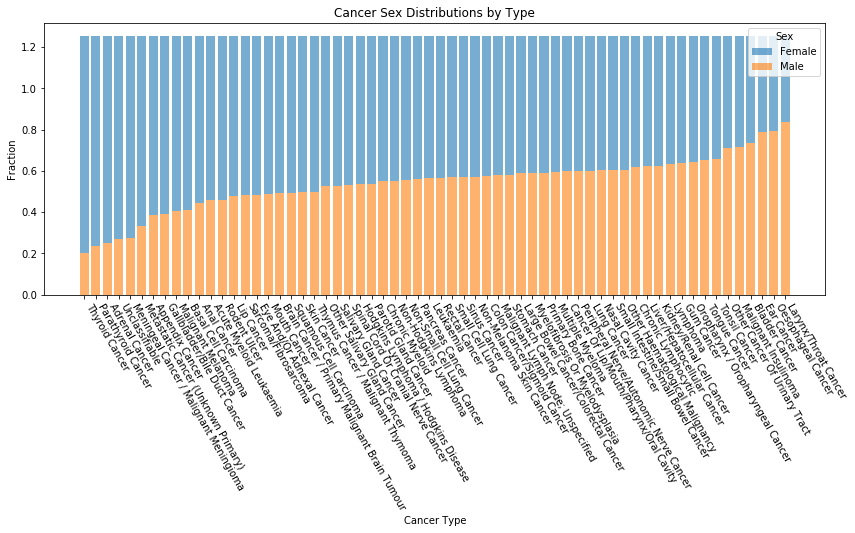

In [75]:
fig, ax = plt.subplots(figsize=(14, 5))
data = grouping_df.sort_values("male_fraction")
ax.bar(data=data, x="cancer_code", height="female_fraction",
       bottom="male_fraction", label="Female", alpha=.6)
ax.bar(data=data, x="cancer_code", height="male_fraction", label="Male", alpha=.6)
plt.draw()
add_plt_labels(ax=ax, x="Cancer Type", y="Fraction")
ax.legend(title="Sex")
ax.set_title("Cancer Sex Distributions by Type")
ax.set_xticklabels([t._text.title() for t in ax.get_xticklabels()], rotation="-60", ha="left");

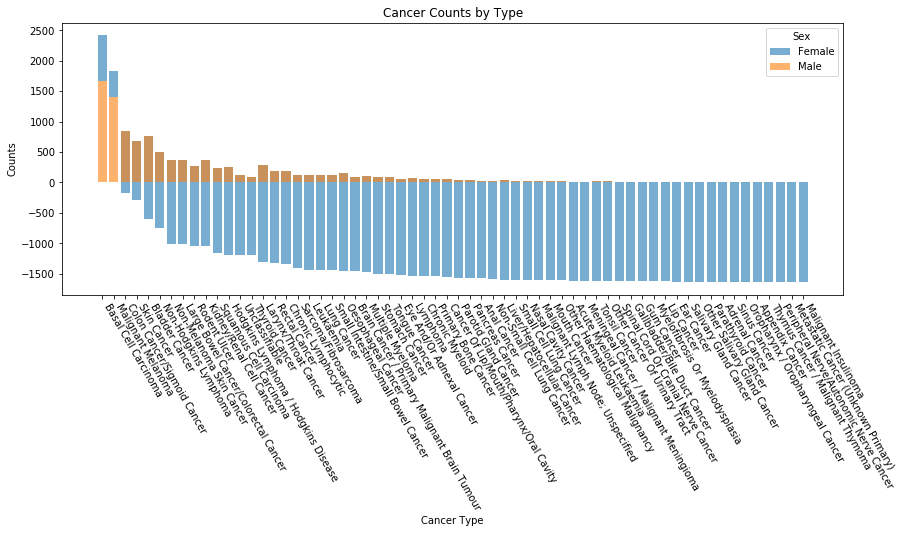

In [76]:
fig, ax = plt.subplots(figsize=(14, 5))
data = grouping_df.sort_values("total", ascending=False)
ax.bar(data=data, x="cancer_code", height="female", bottom="male", label="Female", alpha=.6)
ax.bar(data=data, x="cancer_code", height="male", label="Male", alpha=.6)
plt.draw()
add_plt_labels(ax=ax, x="Cancer Type", y="Counts")
ax.legend(title="Sex")
ax.set_title("Cancer Counts by Type")
ax.set_xticklabels([t._text.title() for t in ax.get_xticklabels()], rotation="-60", ha="left");

In [ ]:
fig, ax = plt.subplots(figsize=(16, 5))
data = cancer_data.loc[cancer_data["cancer_code"].isin(most_common_cancers)].copy(deep=True)

sort_df = data.query("sex == 'Female'")[["cancer_dx_age_interpolated", "cancer_code"]
                                     ].groupby("cancer_code").median().reset_index()
sort_dict = dict(zip(sort_df["cancer_code"], sort_df["cancer_dx_age_interpolated"]))
sort_function = lambda key: sort_dict[key]
sort_function = np.vectorize(sort_function)

data["sort"] = data["cancer_code"].apply(sort_function)
data = data.sort_values("sort")
sns.boxplot(data=data, x="cancer_code", y="cancer_dx_age_interpolated", hue="sex", ax=ax)
ax.set_xticklabels([t._text.title() for t in ax.get_xticklabels()], rotation="-60", ha="left");

In [72]:
from utilities import *

C:\Users\Cole\Miniconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Cole\Miniconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Cole\Miniconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until

C:\Users\Cole\Miniconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Cole\Miniconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Cole\Miniconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until

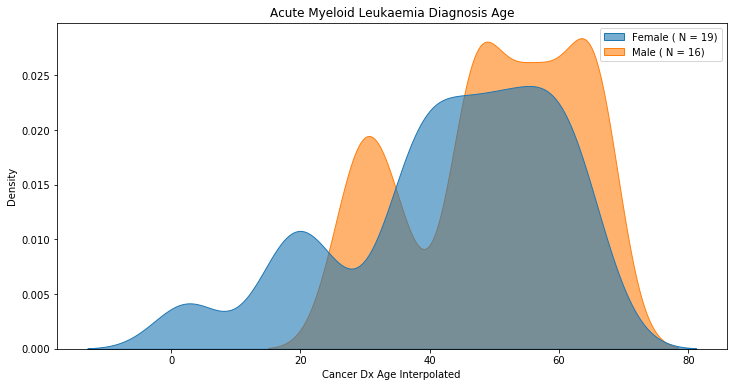

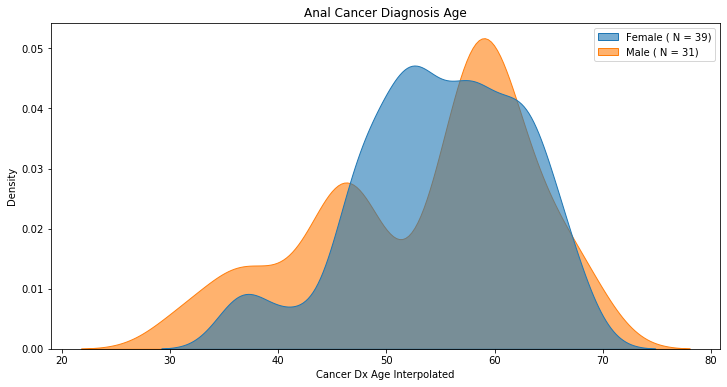

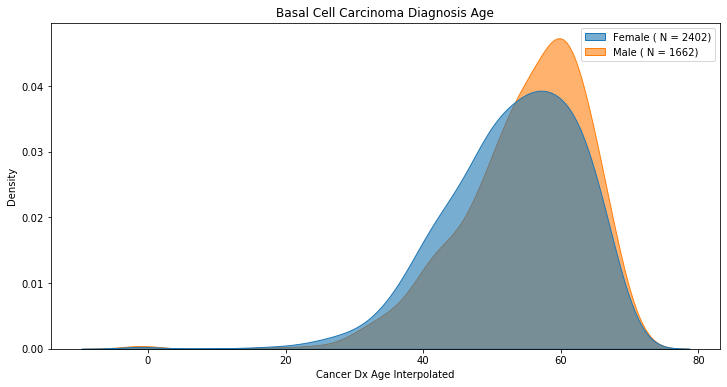

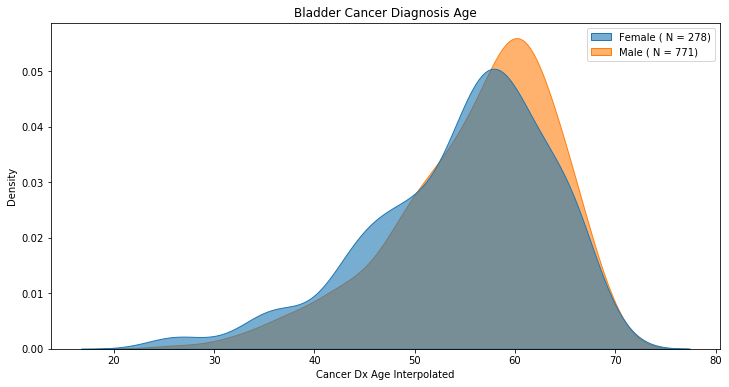

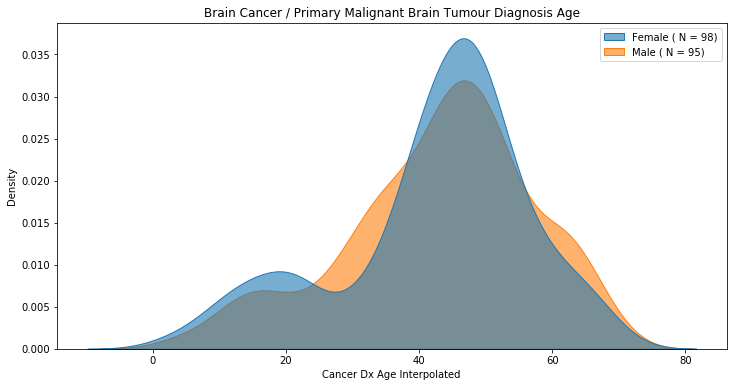

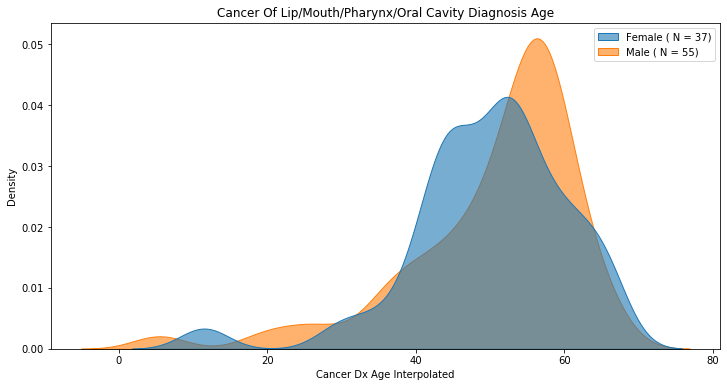

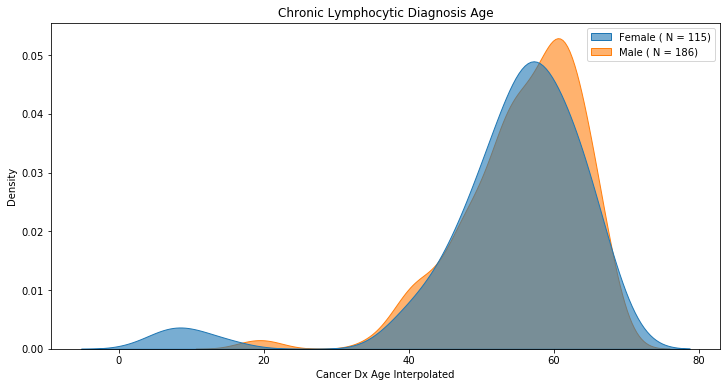

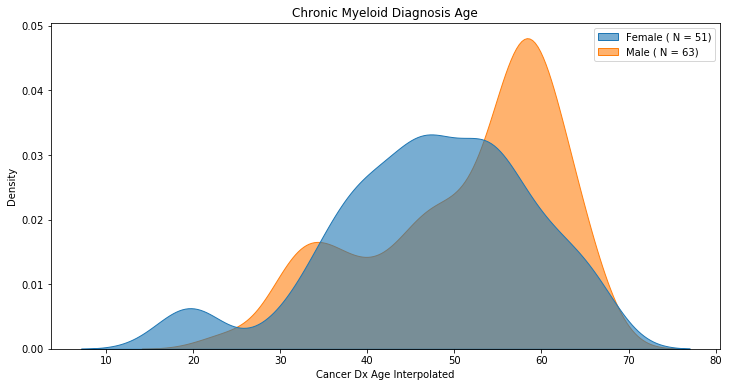

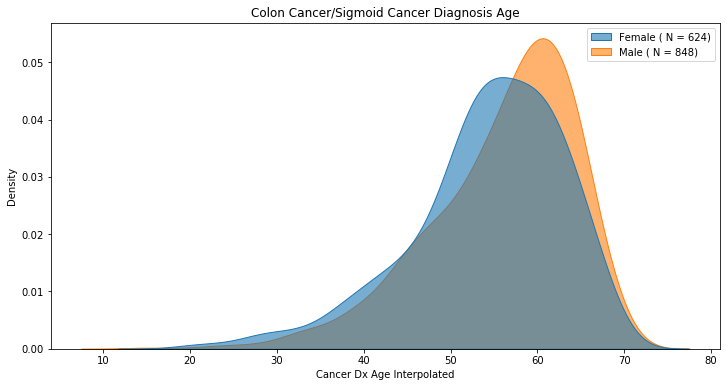

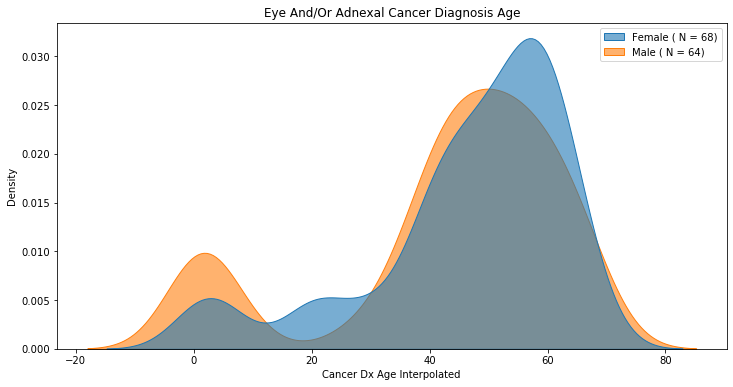

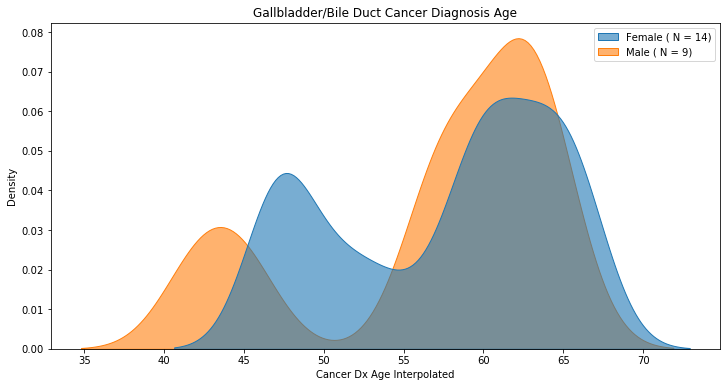

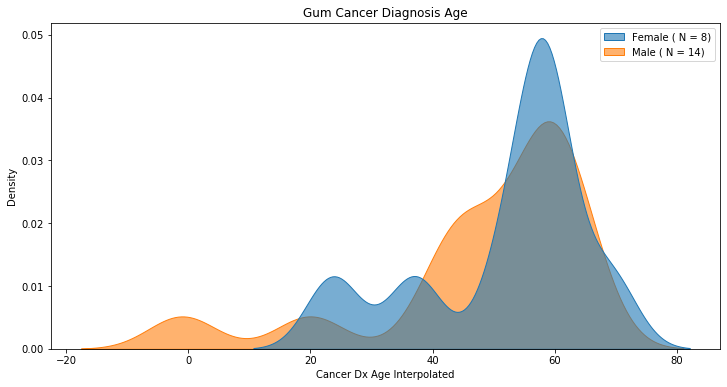

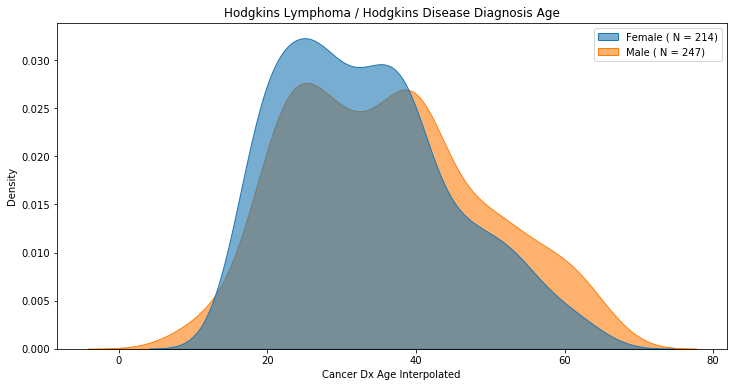

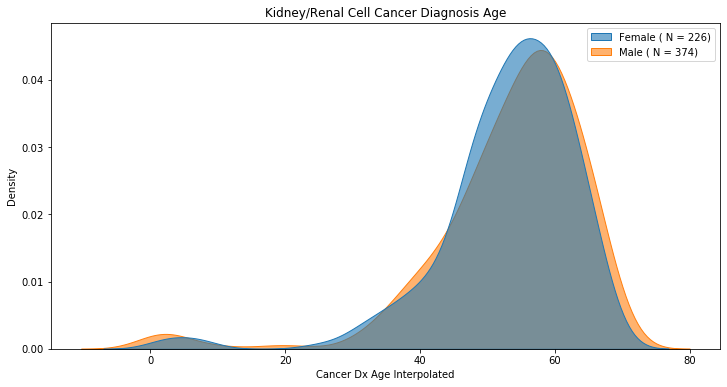

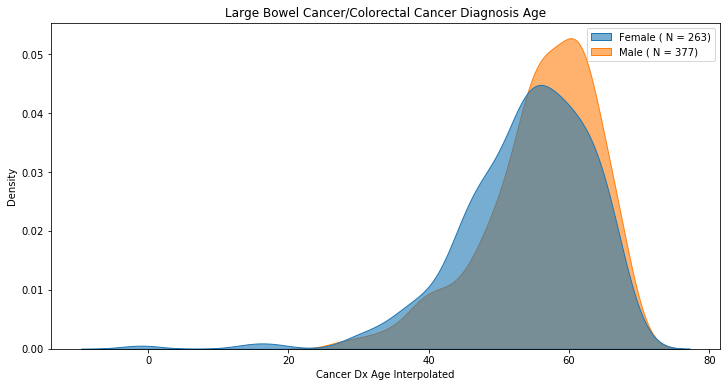

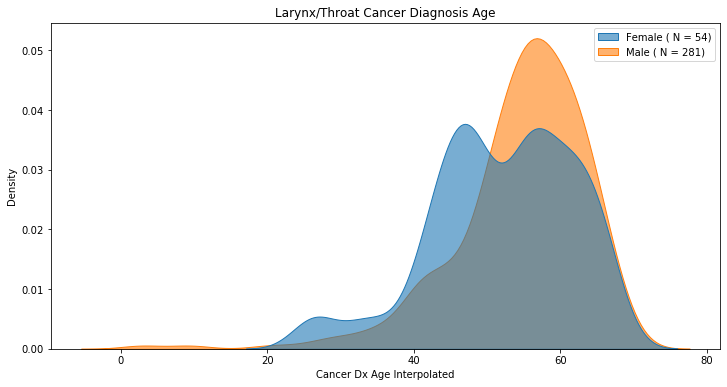

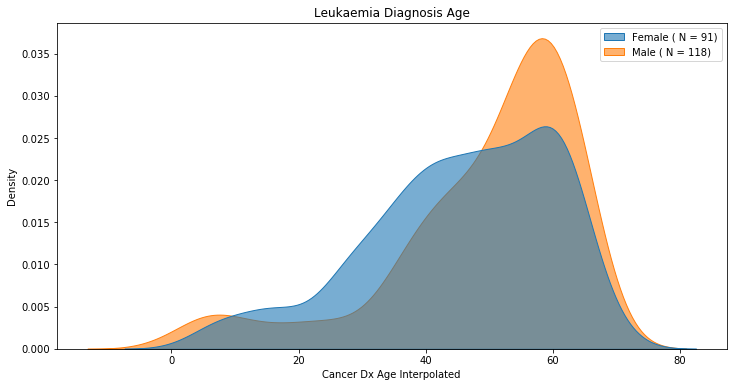

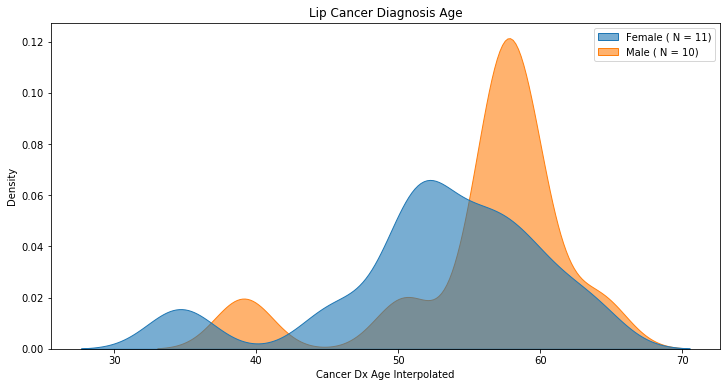

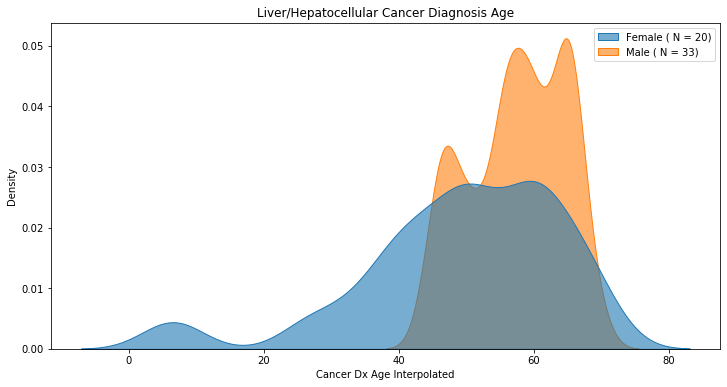

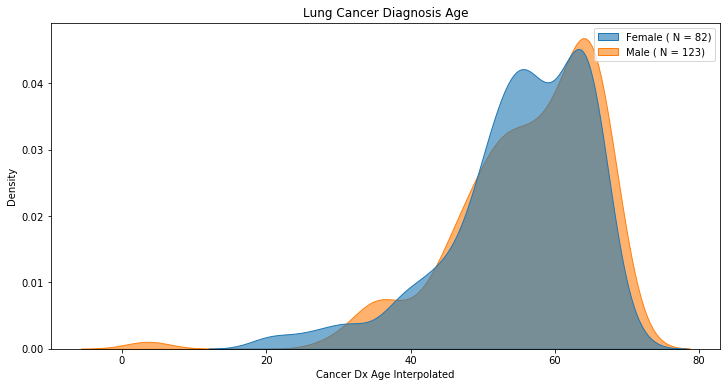

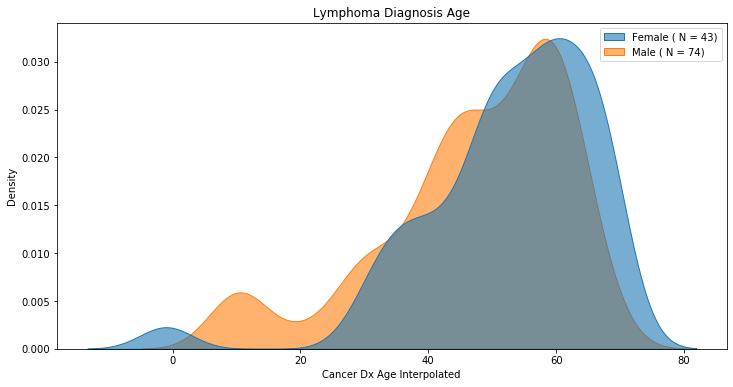

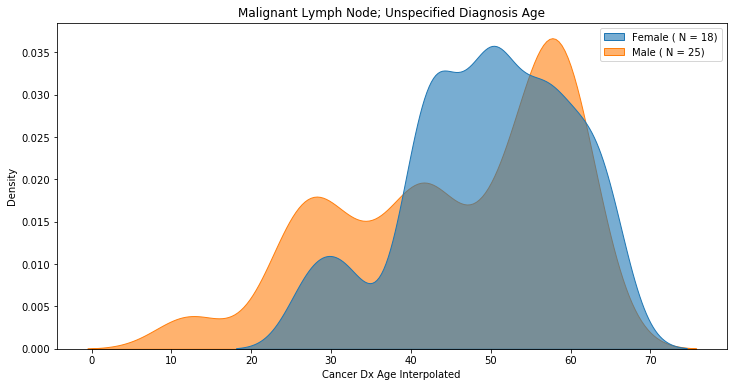

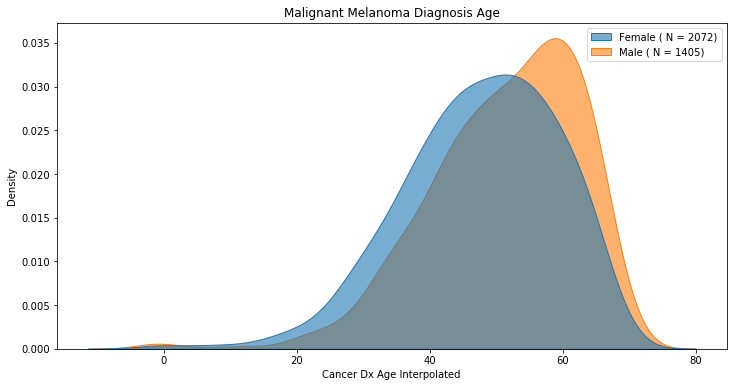

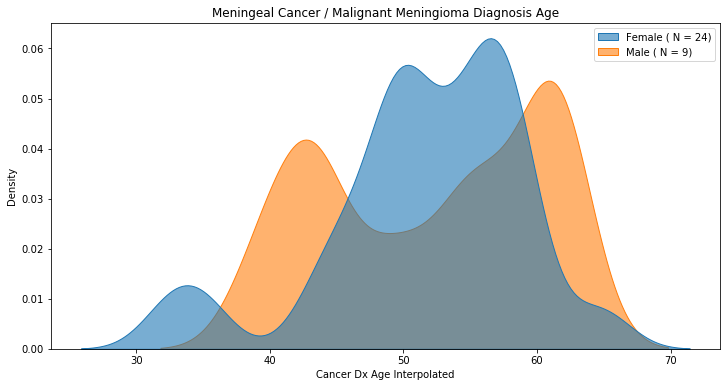

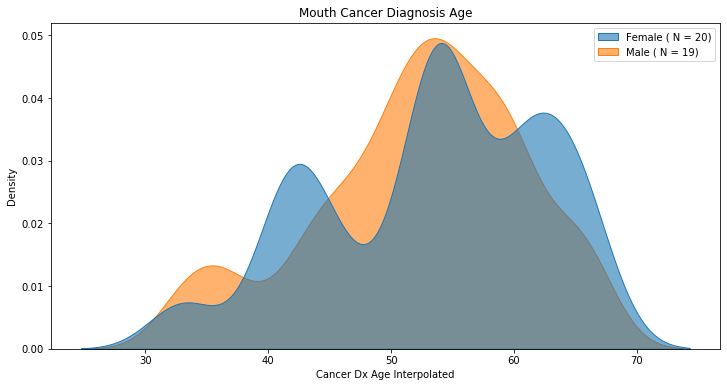

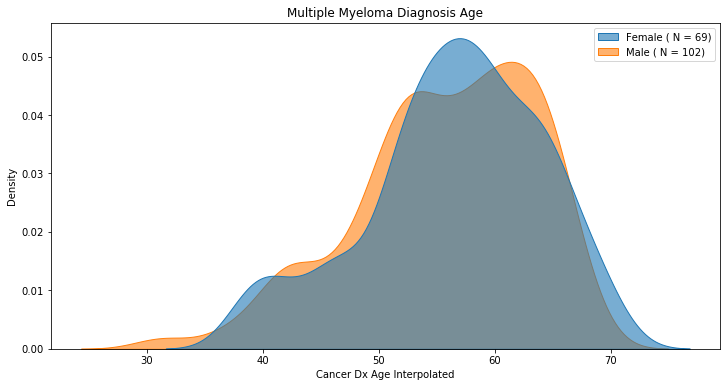

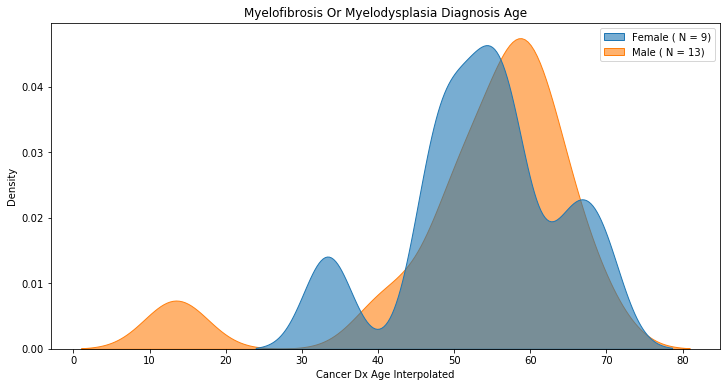

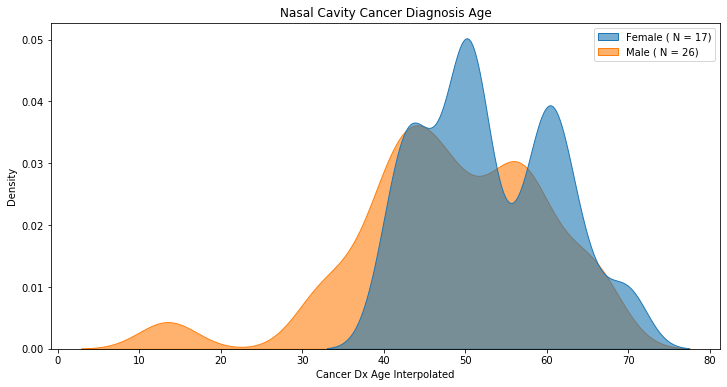

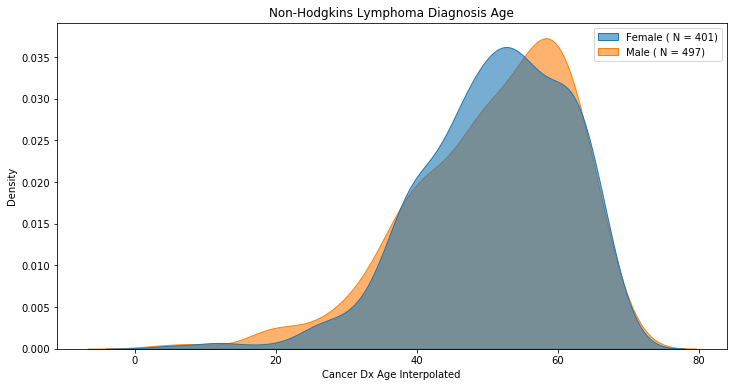

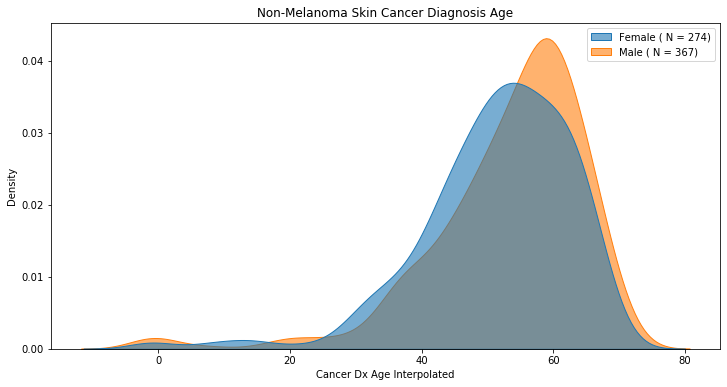

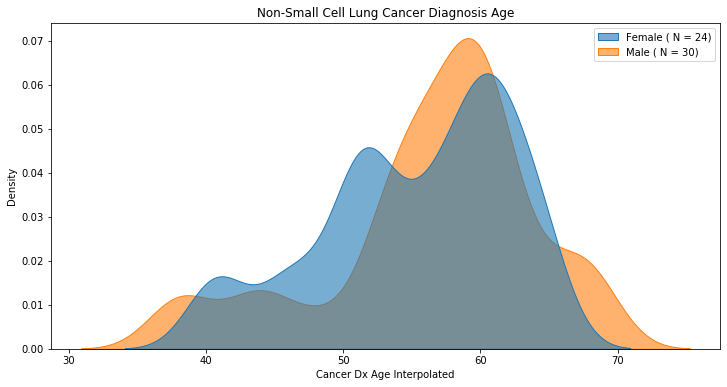

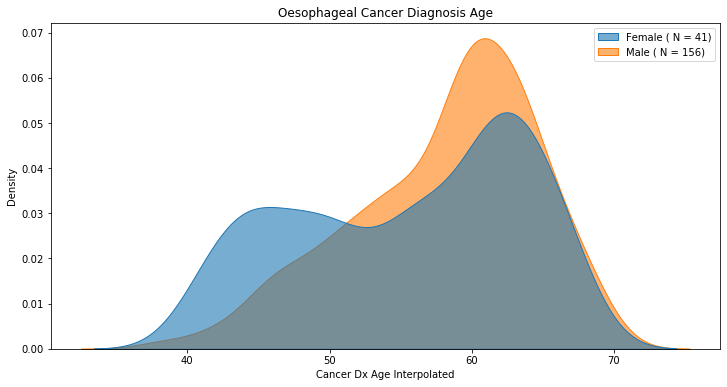

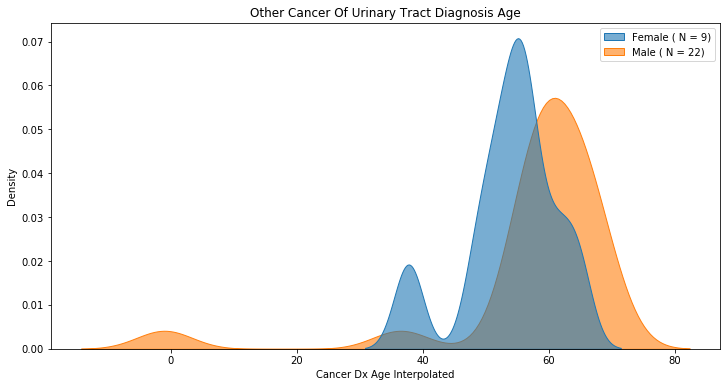

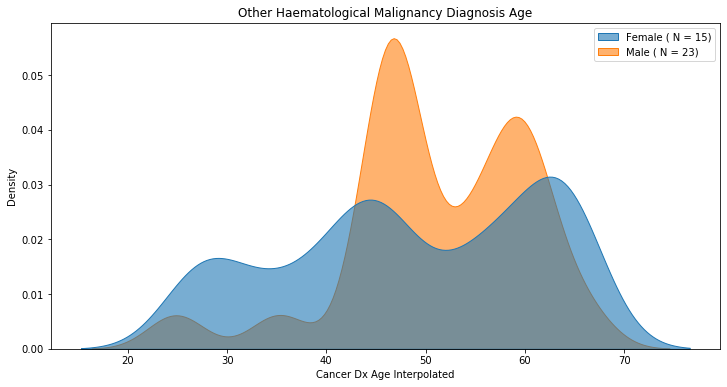

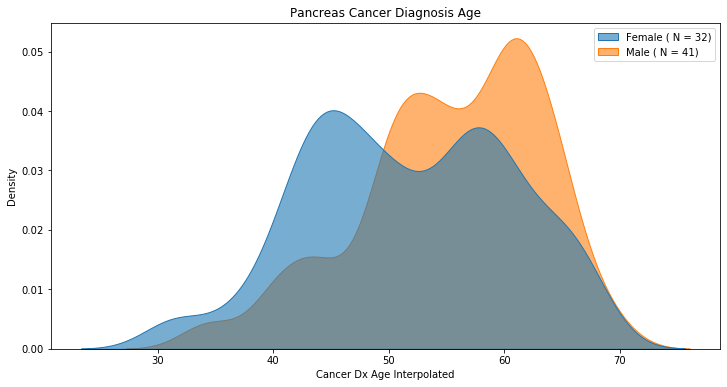

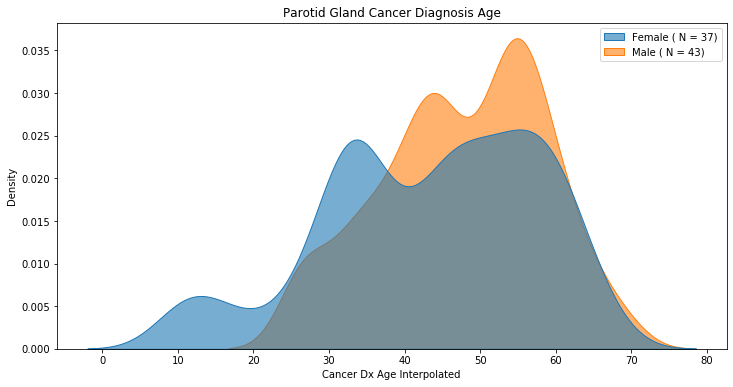

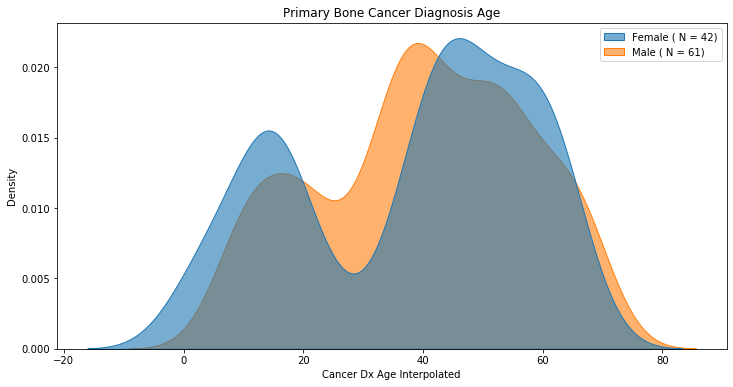

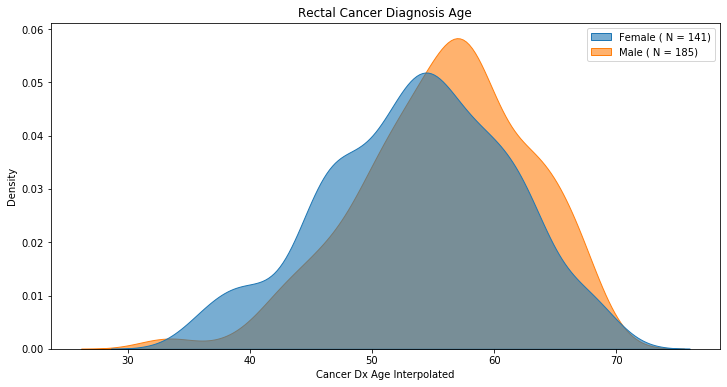

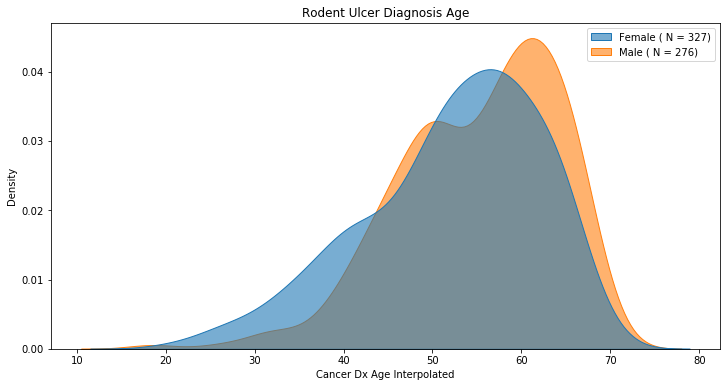

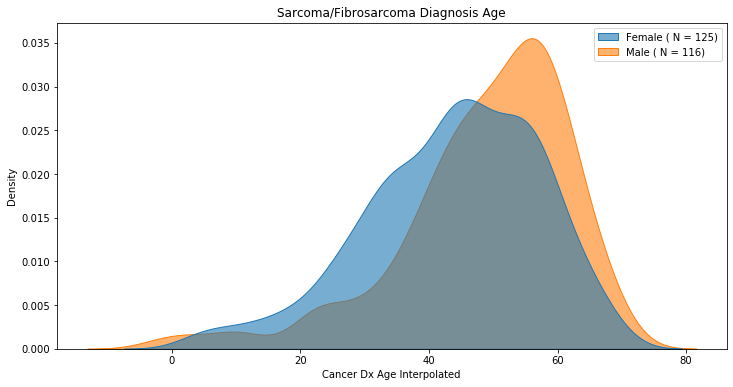

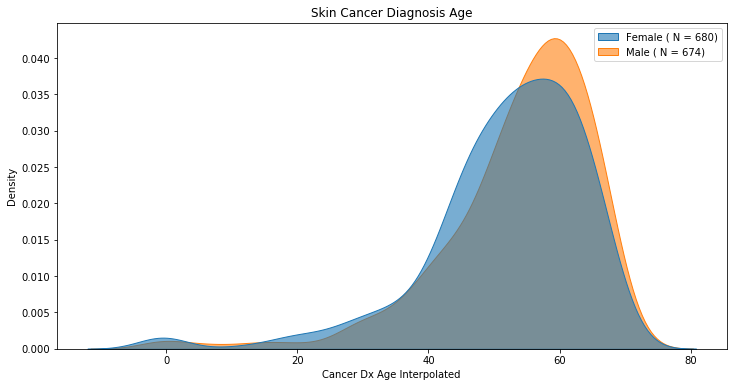

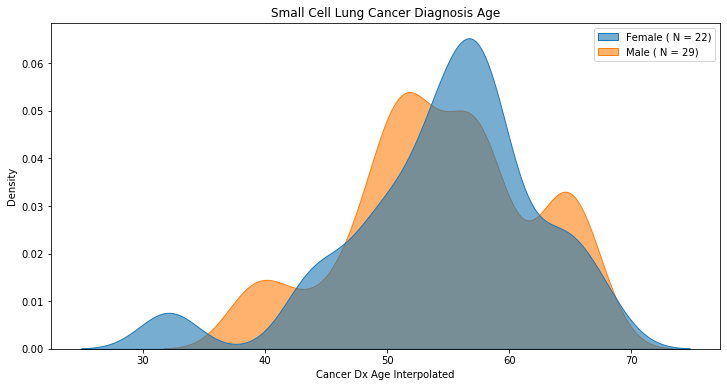

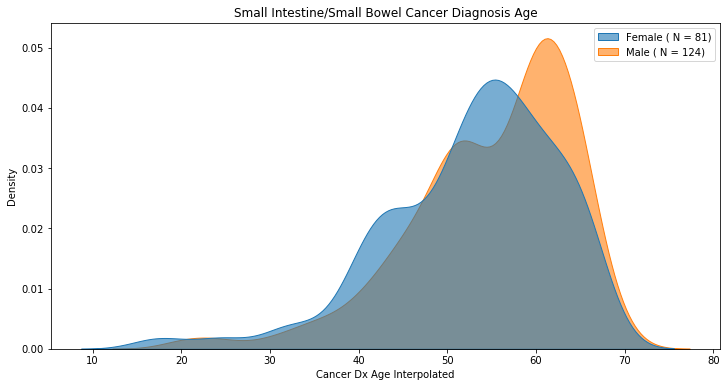

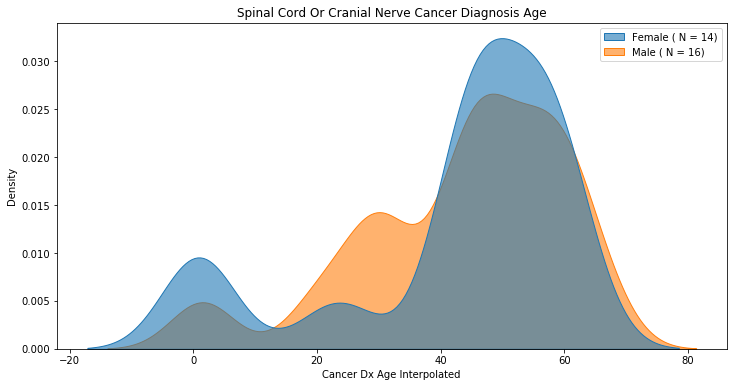

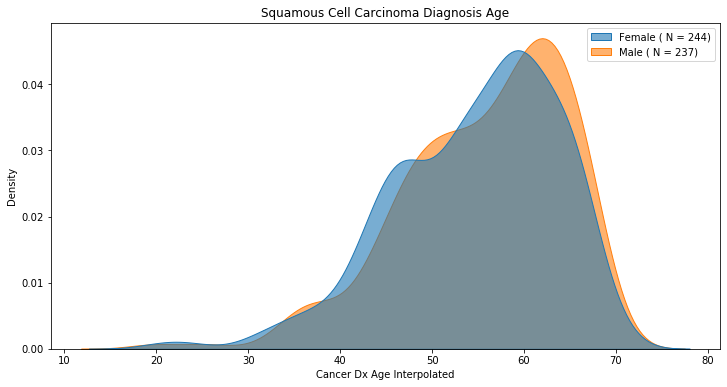

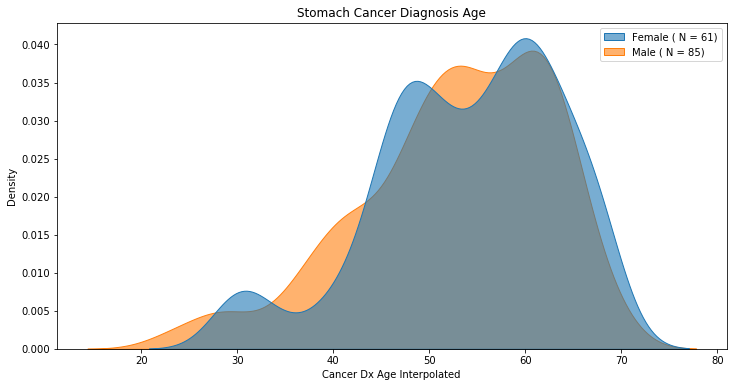

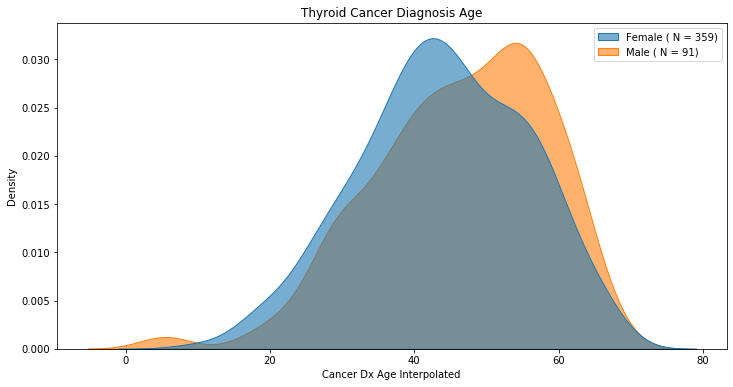

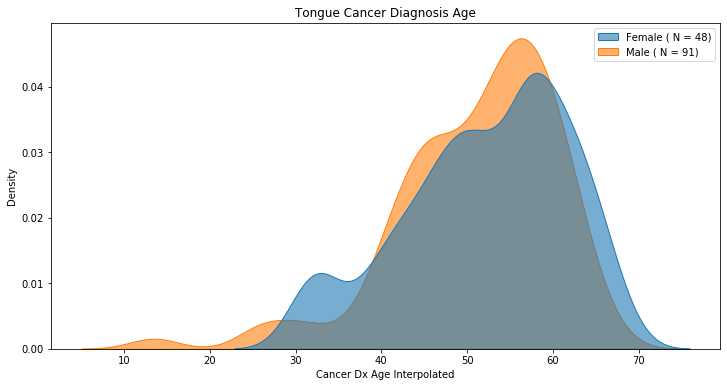

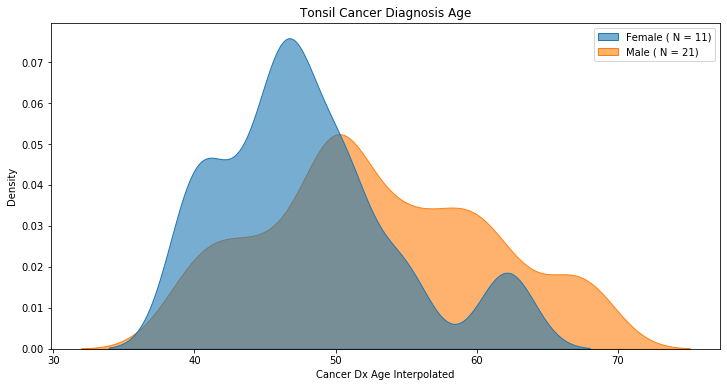

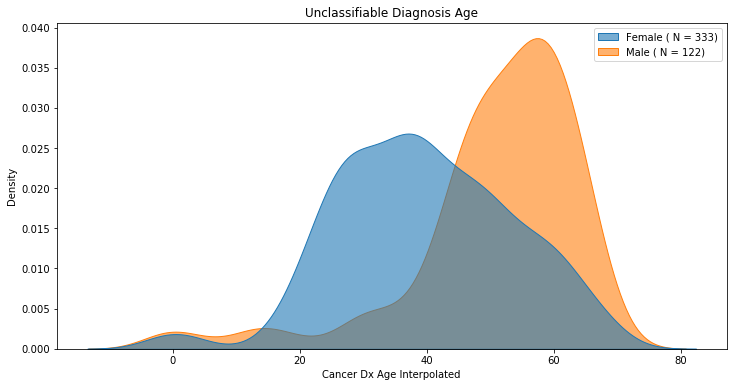

In [73]:
x, y, hue = "cancer_dx_age_interpolated", "density", "sex"
cancer_types = exclude(sorted(cancer_data["cancer_code"].unique()), sex_specific_cancers)

for cancer_code in cancer_types:
    data = cancer_data.query(f"cancer_code == '{cancer_code}'")
    counts = np.unique(data[hue], return_counts=True)[1]
    if len(data) < 20 or len(counts) <= 1:
        continue
        
    fig, ax = plt.subplots(figsize=(12, 6))
    kde_plot(data=data, x=x, hue=hue, ax=ax, bw_method=.3)
    add_plt_labels(ax, x=x, y=y)
    ax.set_title(f"{cancer_code.title()} Diagnosis Age")

# Viral Associations

In [422]:
data_tools.biobank_search(med_code_mapping, cancer_data, ("ebv"))

,coding,meaning,code_format,name,count
362,1567,infectious mononucleosis / glandular fever / e...,6,illness_code,0
572,9724,SystemicEBV positive T-cell lymphoproliferativ...,38,cancer_tumor_histology,0


In [425]:
MONONUCLEOSIS_LABEL = 'infectious mononucleosis / glandular fever / epstein barr virus (ebv)'
HIV_AIDS_LABELS = "hiv/aids"
